In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import recall_score, confusion_matrix
from scripts.model_functions import *
from scripts.helper_functions import *
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, Activation

Using TensorFlow backend.


In [2]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 400 

# number of times to repeat process
EPOCHS = 100

# how many points ahead to look
POINTS_AHEAD = 0


In [3]:
# Load the data
df_train = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df_train.head()

df_test = pd.read_csv('../../data/cleaned/site2_bird.csv')

In [4]:
# Adding time stamp 
from datetime import datetime

timestamp = df_train['Date (mm.dd.yyyy)'] + ' '+ df_train['Time 24hr']
timestamp = pd.to_datetime(timestamp)
df_train['Timestamp'] = timestamp
df_train.head()

timestamp = df_test['Date (mm.dd.yyyy)'] + ' '+ df_test['Time 24hr']
timestamp = pd.to_datetime(timestamp)
df_test['Timestamp'] = timestamp
df_test.head()


,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1,2017-05-05 00:00:00
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1,2017-05-05 00:15:00
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2,2017-05-05 00:30:00
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2,2017-05-05 00:45:00
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1,2017-05-05 01:00:00


In [5]:
# dont need data and time now that we have Timestamp. Lets remove them

df_train = df_train.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
df_train.head(5)

df_test = df_test.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
df_test.head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1,2017-05-05 00:00:00
1,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1,2017-05-05 00:15:00
2,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2,2017-05-05 00:30:00
3,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2,2017-05-05 00:45:00
4,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1,2017-05-05 01:00:00


In [6]:
# lets try to normalize this now....
train_target = df_train['BGA-Phycocyanin RFU']
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)','Chlorophyll RFU']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(df_train[dataset_columns])
df_train = pd.DataFrame(ds_scaled,columns=dataset_columns)
df_train['BGA-Phycocyanin RFU'] = train_target
df_train.describe()

# lets try to normalize this now....
test_target = df_test['BGA-Phycocyanin RFU']
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)','Chlorophyll RFU']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(df_test[dataset_columns])
df_test = pd.DataFrame(ds_scaled,columns=dataset_columns)
df_test['BGA-Phycocyanin RFU'] = test_target
df_test.describe()

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),Chlorophyll RFU,BGA-Phycocyanin RFU
count,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000
mean,0.557140,0.858878,0.206929,0.800655,0.014204,0.503941,0.599940,0.048836,0.762550
std,0.280796,0.057788,0.086697,0.091744,0.020237,0.083285,0.120033,0.031342,0.630421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.280773,0.829966,0.167293,0.759563,0.006112,0.483530,0.524031,0.030120,0.400000
50%,0.619946,0.855640,0.190789,0.814208,0.008997,0.504040,0.611628,0.044177,0.600000
75%,0.815139,0.881313,0.240602,0.857923,0.014504,0.523928,0.695349,0.062249,0.900000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.600000


In [7]:
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)', 'Chlorophyll RFU']
(x_train, y_train) = segment_dataset(df_train, dataset_columns , 'BGA-Phycocyanin RFU', 7, pts_ahead=POINTS_AHEAD)
(x_test, y_test) = segment_dataset(df_test, dataset_columns , 'BGA-Phycocyanin RFU', 7, pts_ahead=POINTS_AHEAD)



WINDOW SIZE 7
NUMBER OF COULUMNS 8
LOOKING AHEAD 0 points
Window Segmentation 0.56% done
Window Segmentation 1.09% done
Window Segmentation 1.62% done
Window Segmentation 2.15% done
Window Segmentation 2.68% done
Window Segmentation 3.20% done
Window Segmentation 3.73% done
Window Segmentation 4.26% done
Window Segmentation 4.79% done
Window Segmentation 5.31% done
Window Segmentation 5.84% done
Window Segmentation 6.37% done
Window Segmentation 6.90% done
Window Segmentation 7.43% done
Window Segmentation 7.95% done
Window Segmentation 8.48% done
Window Segmentation 9.01% done
Window Segmentation 9.54% done
Window Segmentation 10.06% done
Window Segmentation 10.59% done
Window Segmentation 11.12% done
Window Segmentation 11.65% done
Window Segmentation 12.18% done
Window Segmentation 12.70% done
Window Segmentation 13.23% done
Window Segmentation 13.76% done
Window Segmentation 14.29% done
Window Segmentation 14.82% done
Window Segmentation 15.34% done
Window Segmentation 15.87% done


Window Segmentation 38.65% done
Window Segmentation 39.23% done
Window Segmentation 39.82% done
Window Segmentation 40.40% done
Window Segmentation 40.99% done
Window Segmentation 41.57% done
Window Segmentation 42.16% done
Window Segmentation 42.74% done
Window Segmentation 43.33% done
Window Segmentation 43.91% done
Window Segmentation 44.50% done
Window Segmentation 45.08% done
Window Segmentation 45.67% done
Window Segmentation 46.25% done
Window Segmentation 46.84% done
Window Segmentation 47.42% done
Window Segmentation 48.01% done
Window Segmentation 48.59% done
Window Segmentation 49.18% done
Window Segmentation 49.76% done
Window Segmentation 50.35% done
Window Segmentation 50.93% done
Window Segmentation 51.52% done
Window Segmentation 52.10% done
Window Segmentation 52.69% done
Window Segmentation 53.27% done
Window Segmentation 53.86% done
Window Segmentation 54.44% done
Window Segmentation 55.03% done
Window Segmentation 55.61% done
Window Segmentation 56.20% done
Window S

In [8]:
print("TRAIN SHAPE",x_train.shape)
print("TEST SHAPE",x_test.shape)

TRAIN SHAPE (18940, 7, 8)
TEST SHAPE (17088, 7, 8)


In [9]:
print("TRAIN TARGETS", y_train.shape)
print("TEST TARGETS", y_test.shape)

TRAIN TARGETS (18940,)
TEST TARGETS (17088,)


## Shaping the data to be used in the model.

In [10]:
x_train = x_train.reshape(len(x_train),7,8)
x_train.shape

x_test = x_test.reshape(len(x_test),7,8)
x_test.shape

(17088, 7, 8)

In [11]:
print(x_train[0])

[[0.40932868 0.8537714  0.69430052 0.33076923 0.02543865 0.18652144
  0.35181818 0.04814815]
 [0.40802092 0.85330865 0.69430052 0.33076923 0.02531287 0.18652144
  0.35181818 0.04444444]
 [0.40671316 0.85330865 0.69430052 0.33076923 0.02540721 0.18584071
  0.35181818 0.04814815]
 [0.40627724 0.8537714  0.69430052 0.33076923 0.02598893 0.18515997
  0.35090909 0.04814815]
 [0.40496949 0.8537714  0.69559585 0.33076923 0.02545437 0.1837985
  0.35       0.04814815]
 [0.40496949 0.8546969  0.69430052 0.33076923 0.02479404 0.1837985
  0.35       0.05185185]
 [0.40409765 0.85515965 0.69430052 0.33076923 0.02466826 0.18311777
  0.34909091 0.04814815]]


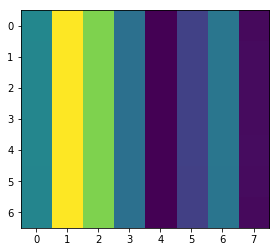

In [12]:
plt.imshow(x_train[1])

## Breaking apart training and test data

In [13]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (18940, 7, 8)
x_test shape: (17088, 7, 8)
y_train shape: (18940,)
y_test shape: (17088,)


In [14]:
if POINTS_AHEAD > 0:
    y_train = y_train.reshape(y_train.shape[0],y_train.shape[1])
    y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
else:
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (18940, 1)
y_test shape: (17088, 1)


## Build the CNN model

The determining factor of a CNN model is at least one Convolutional layer in the model. so lets try to build something to see what kind of metrics that we are getting. 

In [15]:
model = Sequential()
model.add(Conv1D(40,kernel_size=(4),input_shape=(x_test.shape[1],x_test.shape[2])))
model.add(Dense(40))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Flatten())
model.add(Dense(y_test.shape[1]))
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mse']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 40)             1320      
_________________________________________________________________
dense_1 (Dense)              (None, 4, 40)             1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 40)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4, 20)             820       
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 3,861
Trainable params: 3,861
Non-trainable params: 0
_________________________________________________________________


In [16]:
print(y_test[0])

[0.2]


In [17]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
# What is our score?

score = model.evaluate(x_test, y_test, verbose=1)
cnn_predictions = model.predict(x_test)
print("Loss {} MSE {}".format(score[0], score[1]))

Epoch 1/100
18940/18940 [==============================] - 4s 227us/step - loss: 0.4986 - mean_squared_error: 0.4986
Epoch 2/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3803 - mean_squared_error: 0.3803
Epoch 3/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3609 - mean_squared_error: 0.3609
Epoch 4/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3605 - mean_squared_error: 0.3605
Epoch 5/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3557 - mean_squared_error: 0.3557
Epoch 6/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3567 - mean_squared_error: 0.3567
Epoch 7/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3517 - mean_squared_error: 0.3517
Epoch 8/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3491 - mean_squared_error: 0.3491
Epoch 9/100
18940/18940 [==============================] - 0s 10us/step - l

18940/18940 [==============================] - 0s 11us/step - loss: 0.3299 - mean_squared_error: 0.3299
Epoch 72/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3303 - mean_squared_error: 0.3303
Epoch 73/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3308 - mean_squared_error: 0.3308
Epoch 74/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3297 - mean_squared_error: 0.3297
Epoch 75/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3275 - mean_squared_error: 0.3275
Epoch 76/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3301 - mean_squared_error: 0.3301
Epoch 77/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3277 - mean_squared_error: 0.3277
Epoch 78/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3286 - mean_squared_error: 0.3286
Epoch 79/100
18940/18940 [==============================] - 0s 10us/step - lo

## Building a regression model

Experimenting to see if a regression model will help with doing predicting a 

In [18]:
model = Sequential()
model.add(Dense(40, input_shape=(x_test.shape[1],x_test.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Flatten())
model.add(Dense(y_test.shape[1]))
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mse']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 7, 40)             360       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 40)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 7, 20)             820       
_________________________________________________________________
flatten_2 (Flatten)          (None, 140)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 141       
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
# What is our score?
score = model.evaluate(x_test, y_test, verbose=1)
linear_predictions = model.predict(x_test)
print("Loss {} MSE {}".format(score[0], score[1]))

Epoch 1/100
18940/18940 [==============================] - 1s 30us/step - loss: 0.5024 - mean_squared_error: 0.5024
Epoch 2/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3886 - mean_squared_error: 0.3886
Epoch 3/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3651 - mean_squared_error: 0.3651
Epoch 4/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3551 - mean_squared_error: 0.3551
Epoch 5/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3470 - mean_squared_error: 0.3470
Epoch 6/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3428 - mean_squared_error: 0.3428
Epoch 7/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3388 - mean_squared_error: 0.3388
Epoch 8/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3382 - mean_squared_error: 0.3382
Epoch 9/100
18940/18940 [==============================] - 0s 9us/step - loss: 

18940/18940 [==============================] - 0s 10us/step - loss: 0.3259 - mean_squared_error: 0.3259
Epoch 72/100
18940/18940 [==============================] - 0s 10us/step - loss: 0.3265 - mean_squared_error: 0.3265
Epoch 73/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3259 - mean_squared_error: 0.3259
Epoch 74/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3256 - mean_squared_error: 0.3256
Epoch 75/100
18940/18940 [==============================] - 0s 8us/step - loss: 0.3272 - mean_squared_error: 0.3272
Epoch 76/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3265 - mean_squared_error: 0.3265
Epoch 77/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3264 - mean_squared_error: 0.3264
Epoch 78/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3272 - mean_squared_error: 0.3272
Epoch 79/100
18940/18940 [==============================] - 0s 9us/step - loss: 0.3

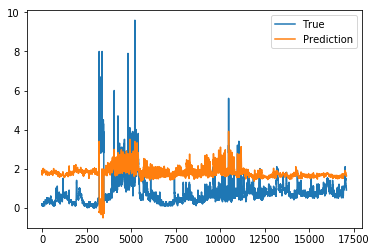

In [20]:
lines = pd.DataFrame({'True':y_test.reshape(y_test.shape[0]), 'Prediction':linear_predictions.reshape(linear_predictions.shape[0])})
lines.plot()

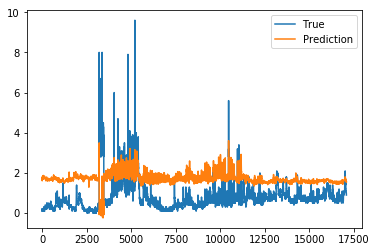

In [22]:
lines = pd.DataFrame({'True':y_test.reshape(y_test.shape[0]), 'Prediction':cnn_predictions.reshape(cnn_predictions.shape[0])})
lines.plot()